# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [1]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
#
#HELLO This is my change
# I want to see more webscraping libarys in python
print('Hello PM')

Hello PM


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.


Grid set



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in square
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less



Plotting using imshow()

plotting done


Preparing to render



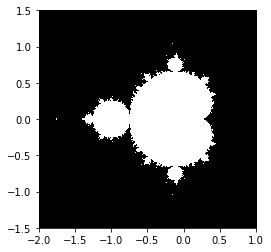

In [17]:

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

x,y=np.ogrid[-2:1:5000j,-1.5:1.5:5000j]

print('')
print('Grid set')
print('')

c=x + 1j*y
z=0

for g in range(50):
        z=z**2 + c

threshold = 2
mask=np.abs(z) < threshold

print('')
print('Plotting using imshow()')
plt.imshow(mask.T,extent=[-2,1,-1.5,1.5])

print('')
print('plotting done')
print('')

plt.gray()

print('')
print('Preparing to render')
print('')

plt.show()



### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




1: I found some code that computes and graphs the Mandelbrot set. 

2: It wasn't that challenging because I copped the code off of someone. I did edit the code a little bit so that it would print all of the numbers that it is computing.

3: The code looks really efficient and looks really clean,with a simple loop you can calculate the Mandelbrot set.

4: With more time I would of tried to add color to this code and zoom in on the fractal to make one of those cool videos  on fractals on youtube


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.